# SECCIÓN 1: ANÁLISIS DE SENTIMIENTOS

In [25]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Inicializar el analizador de sentimientos de VADER
analyzer = SentimentIntensityAnalyzer()

# Diccionario de emociones para clasificar
sentimientos = {
    'positivo': 0, 
    'negativo': 1, 
    'neutral': 2
}

# Palabras clave y frases específicas del dialecto ecuatoriano para emociones negativas
palabras_clave_negativas = [
    'sinvergüenza', 'charlatán', 'mañoso', 'corrupto', 'inútil', 'maldito', 'ladrón', 'hipócrita',
    'vergonzoso', 'mentiroso', 'desgraciado', 'canalla', 'ratero'
]

# Función para clasificar el sentimiento basado en el análisis de VADER y palabras clave específicas
def clasificar_sentimiento(comentario):
    analisis = TextBlob(comentario)
    vader_result = analyzer.polarity_scores(comentario)
    
    # Clasificación basada en el análisis de VADER
    if vader_result['compound'] >= 0.05:
        return 'positivo'
    elif vader_result['compound'] <= -0.05:
        return 'negativo'
    
    # Clasificación adicional basada en palabras clave específicas
    for palabra in palabras_clave_negativas:
        if palabra in comentario:
            return 'negativo'
    
    return 'neutral'

def analizar_sentimientos(df):
    emociones = {'positivo': [], 'negativo': [], 'neutral': []}
    
    aspectos = []
    sentim = []

    for index, row in df.iterrows():
        comentario = row['comment_limpio']
        sentimiento = clasificar_sentimiento(comentario)
        emociones[sentimiento].append(comentario)
        aspectos.append(sentimiento)
        sentim.append(sentimientos[sentimiento])
    
    df['aspecto'] = aspectos
    df['sentimiento'] = sentim  # Asegúrate de que esta columna se cree correctamente
    return df, emociones

In [26]:
import pandas as pd

def comparar_aspectos(df):
    # Implementación de la función para comparar aspectos
    pass  # Reemplaza con la lógica real


In [27]:
import pandas as pd

def identificar_temas(df):
    # Aquí va la lógica para identificar temas
    # Por ahora, simplemente devolvamos una lista vacía como ejemplo
    temas = []
    return temas


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def generar_matriz_confusion(y_true, y_pred, labels, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

def generar_visualizaciones(df, y_true, y_pred, labels):
    # Mapeo de los sentimientos para etiquetas comprensibles
    sentimiento_map = {0: 'alegría', 1: 'enojo', 2: 'tristeza', 3: 'satisfacción', 4: 'insatisfacción'}
    df['sentimiento_label'] = df['sentimiento'].map(sentimiento_map)

    # Crear figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis de Sentimientos y Aspectos', fontsize=16)

    # Conteo de sentimientos
    sns.countplot(x='sentimiento_label', data=df, palette='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Distribución de Sentimientos')
    axes[0, 0].set_xlabel('Sentimientos')
    axes[0, 0].set_ylabel('Conteo')

    # Evolución temporal de los sentimientos
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.resample('M', on='timestamp').size().plot(ax=axes[0, 1])
    axes[0, 1].set_title('Número de Comentarios por Mes')
    axes[0, 1].set_xlabel('Fecha')
    axes[0, 1].set_ylabel('Número de Comentarios')

    # Análisis de temas y aspectos
    if 'aspecto' in df.columns:
        sns.countplot(x='aspecto', data=df, palette='coolwarm', ax=axes[1, 0])
        axes[1, 0].set_title('Distribución de Aspectos')
        axes[1, 0].set_xlabel('Aspectos')
        axes[1, 0].set_ylabel('Conteo')

    # Matriz de confusión
    generar_matriz_confusion(y_true, y_pred, labels, axes[1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# SECCIÓN 2: LIMPIEZA DE DATOS

In [29]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer

# Descargar y cargar manualmente los recursos necesarios de NLTK si no se han descargado previamente
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def limpiar_caracteres(texto):
    if isinstance(texto, str):
        texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto, flags=re.I|re.A)
        return texto_limpio.lower()
    else:
        return ''

def tokenizar_texto(texto):
    tokens = word_tokenize(texto)
    return tokens

def eliminar_stopwords(tokens):
    stopwords_esp = set(stopwords.words('spanish'))
    tokens_filtrados = [token for token in tokens if token.lower() not in stopwords_esp]
    return tokens_filtrados

def lematizar_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens_lemmatizados

def limpiar_datos_fila(fila):
    fila['comment_limpio'] = limpiar_caracteres(fila['comment'])
    tokens = tokenizar_texto(fila['comment_limpio'])
    tokens = eliminar_stopwords(tokens)
    tokens = lematizar_tokens(tokens)
    fila['tokens'] = tokens
    fila['comment_limpio'] = ' '.join(tokens)  # Asegurarse de que 'comment_limpio' contenga los tokens filtrados
    return fila

def cargar_csv(file_name):
    csv_path = os.path.join('datasets', 'datos_combinados_1.csv')
    df = pd.read_csv(csv_path, delimiter=',')
    df.rename(columns={'comment': 'comment'}, inplace=True)  # Asegurarse de que la columna se llama 'comment'
    return df

def limpiar_datos(df):
    filas_limpias = []
    for _, fila in df.iterrows():
        filas_limpias.append(limpiar_datos_fila(fila))
    df_limpio = pd.DataFrame(filas_limpias)
    return df_limpio

def vectorizar_texto(df):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['comment_limpio'])
    return tfidf_matrix, tfidf_vectorizer.get_feature_names_out()

def mostrar_resultados(df, tfidf_matrix, feature_names):
    from collections import Counter
    import matplotlib.pyplot as plt

    all_words = ' '.join(df['comment_limpio']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title('Palabras Más Frecuentes')
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

In [30]:
from sklearn.model_selection import train_test_split

def dividir_datos(df, test_size=0.2, validation_size=0.1):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=validation_size/(1-test_size), random_state=42)
    return train_df, val_df, test_df



# SECCIÓN 3: MODELO RNN

In [31]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import os

def definir_modelo_rnn(vocab_size, max_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=3, activation='softmax'))  # 3 unidades para las 3 clases de sentimientos
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def entrenar_y_guardar_modelo_rnn(model, X_train, y_train, X_val, y_val, tokenizer, epochs=50, batch_size=32):
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1, batch_size=batch_size, verbose=0)
    model.save('modelo_rnn.h5')
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def cargar_modelo_rnn():
    if os.path.exists('modelo_rnn.h5') and os.path.exists('tokenizer.pickle'):
        model = load_model('modelo_rnn.h5')
        with open('tokenizer.pickle', 'rb') as handle:
            tokenizer = pickle.load(handle)
        return model, tokenizer
    else:
        return None, None

def evaluar_modelo_rnn(model, test_df, tokenizer):
    X_test = tokenizer.texts_to_sequences(test_df['comment_limpio'].values)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=50)
    y_test = test_df['sentimiento'].values
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    from sklearn.metrics import classification_report, confusion_matrix
    cr = classification_report(y_test, y_pred_classes, target_names=['positivo', 'negativo', 'neutral'])
    cm = confusion_matrix(y_test, y_pred_classes)
    return cr, cm

def generar_visualizaciones(df, y_test, y_pred_classes, clases):
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Análisis de Sentimientos y Aspectos')

    # Distribución de Sentimientos
    sns.countplot(ax=axes[0, 0], x=df['aspecto'], order=['positivo', 'negativo', 'neutral'])
    axes[0, 0].set_title('Distribución de Sentimientos')
    axes[0, 0].set_xlabel('Sentimiento')
    axes[0, 0].set_ylabel('Conteo')

    # Número de Comentarios por Año
    if 'timestamp' in df.columns:
        df['fecha'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.set_index('fecha', inplace=True)
        df.resample('Y').size().plot(ax=axes[0, 1])
        axes[0, 1].set_title('Número de Comentarios por Año')
        axes[0, 1].set_xlabel('Fecha')
        axes[0, 1].set_ylabel('Número de Comentarios')
    else:
        axes[0, 1].set_title('Número de Comentarios por Año (No disponible)')
        axes[0, 1].set_xlabel('Fecha')
        axes[0, 1].set_ylabel('Número de Comentarios')

    # Distribución de Aspectos
    sns.countplot(ax=axes[1, 0], x=df['aspecto'], order=['positivo', 'negativo', 'neutral'])
    axes[1, 0].set_title('Distribución de Aspectos')
    axes[1, 0].set_xlabel('Aspectos')
    axes[1, 0].set_ylabel('Conteo')

    # Palabras más frecuentes
    from collections import Counter
    all_words = ' '.join(df['comment_limpio']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)
    axes[1, 1].pie(counts, labels=words, autopct='%1.1f%%')
    axes[1, 1].set_title('Palabras Más Frecuentes')

    # Distribución de Opiniones por Año
    if 'timestamp' in df.columns:
        df['año'] = pd.to_datetime(df['timestamp']).dt.year
        sns.countplot(ax=axes[2, 0], data=df, x='año', hue='aspecto', order=sorted(df['año'].unique()))
        axes[2, 0].set_title('Distribución de Opiniones por Año')
        axes[2, 0].set_xlabel('Año')
        axes[2, 0].set_ylabel('Conteo')
    else:
        axes[2, 0].set_title('Distribución de Opiniones por Año (No disponible)')
        axes[2, 0].set_xlabel('Año')
        axes[2, 0].set_ylabel('Conteo')

    # Matriz de Confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2, 1], xticklabels=clases, yticklabels=clases)
    axes[2, 1].set_title('Confusion Matrix')
    axes[2, 1].set_xlabel('Predicted')
    axes[2, 1].set_ylabel('True')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Guardar la figura completa
    fig.savefig('analisis_sentimientos_aspectos.png')
    plt.show()

# SECCIÓN 4: EJECUCIÓN PRINCIPAL

Cargando datos...
Datos cargados: 2878 registros, 3 columnas
           username                 timestamp  \
0      @MarcoGilerM  2023-09-11T13:37:46.000Z   
1  @JoseAnt40060050  2023-09-01T22:39:33.000Z   
2  @MariaMa99904828  2023-05-31T00:22:19.000Z   
3      @patsurfer71  2023-03-30T12:27:34.000Z   
4  @Joselui48173725  2023-02-01T13:43:37.000Z   
5    @juancasaenz76  2023-01-31T18:21:38.000Z   
6     @radialvision  2023-01-30T20:57:29.000Z   
7    @mmendozabelen  2023-01-30T19:11:53.000Z   
8         @HRZManta  2022-07-08T20:08:41.000Z   
9         @HRZManta  2022-06-13T16:33:54.000Z   

                                             comment  
0  eso no es todo al realizarse la transferencia ...  
1  nunca entregaste un hospital para la zona sur ...  
2  a mas de adefesio sinverguenza charlatan cuand...  
3  jipijapa necesita un hospital general que pued...  
4  hay jente que tienen caca en el serebropor k v...  
5  x ej los dos funcionarios atacados a bala en p...  
6  noticias  s

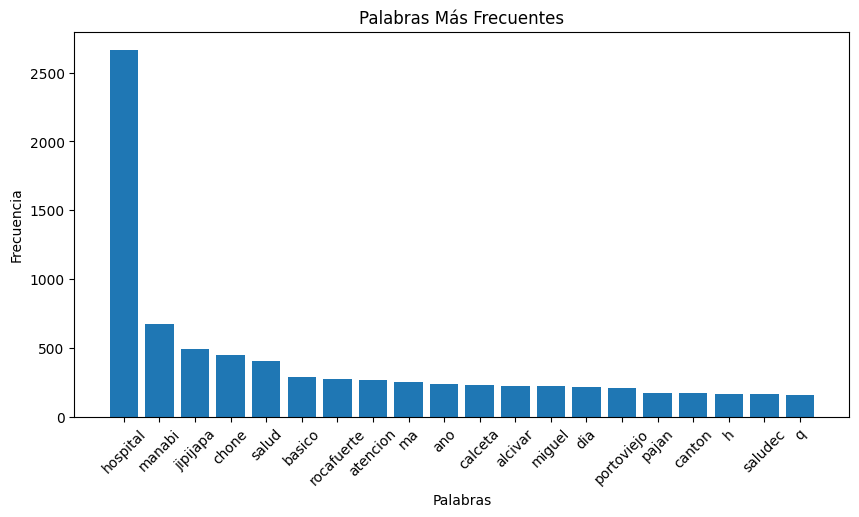

Análisis de sentimientos...
Columnas disponibles después del análisis de sentimientos: Index(['username', 'timestamp', 'comment', 'comment_limpio', 'tokens',
       'aspecto', 'sentimiento'],
      dtype='object')
Emociones detectadas: {'positivo': 206, 'negativo': 103, 'neutral': 2569}
           username                 timestamp  \
0      @MarcoGilerM  2023-09-11T13:37:46.000Z   
1  @JoseAnt40060050  2023-09-01T22:39:33.000Z   
2  @MariaMa99904828  2023-05-31T00:22:19.000Z   
3      @patsurfer71  2023-03-30T12:27:34.000Z   
4  @Joselui48173725  2023-02-01T13:43:37.000Z   
5    @juancasaenz76  2023-01-31T18:21:38.000Z   
6     @radialvision  2023-01-30T20:57:29.000Z   
7    @mmendozabelen  2023-01-30T19:11:53.000Z   
8         @HRZManta  2022-07-08T20:08:41.000Z   
9         @HRZManta  2022-06-13T16:33:54.000Z   

                                             comment  \
0  eso no es todo al realizarse la transferencia ...   
1  nunca entregaste un hospital para la zona sur ...   
2  a

C:\Users\Erick Carreño\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Modelo cargado exitosamente.
Evaluando el modelo...
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Generando visualizaciones...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Erick Carreño\AppData\Local\Temp\ipykernel_1436\3522173506.py:63: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.resample('Y').size().plot(ax=axes[0, 1])


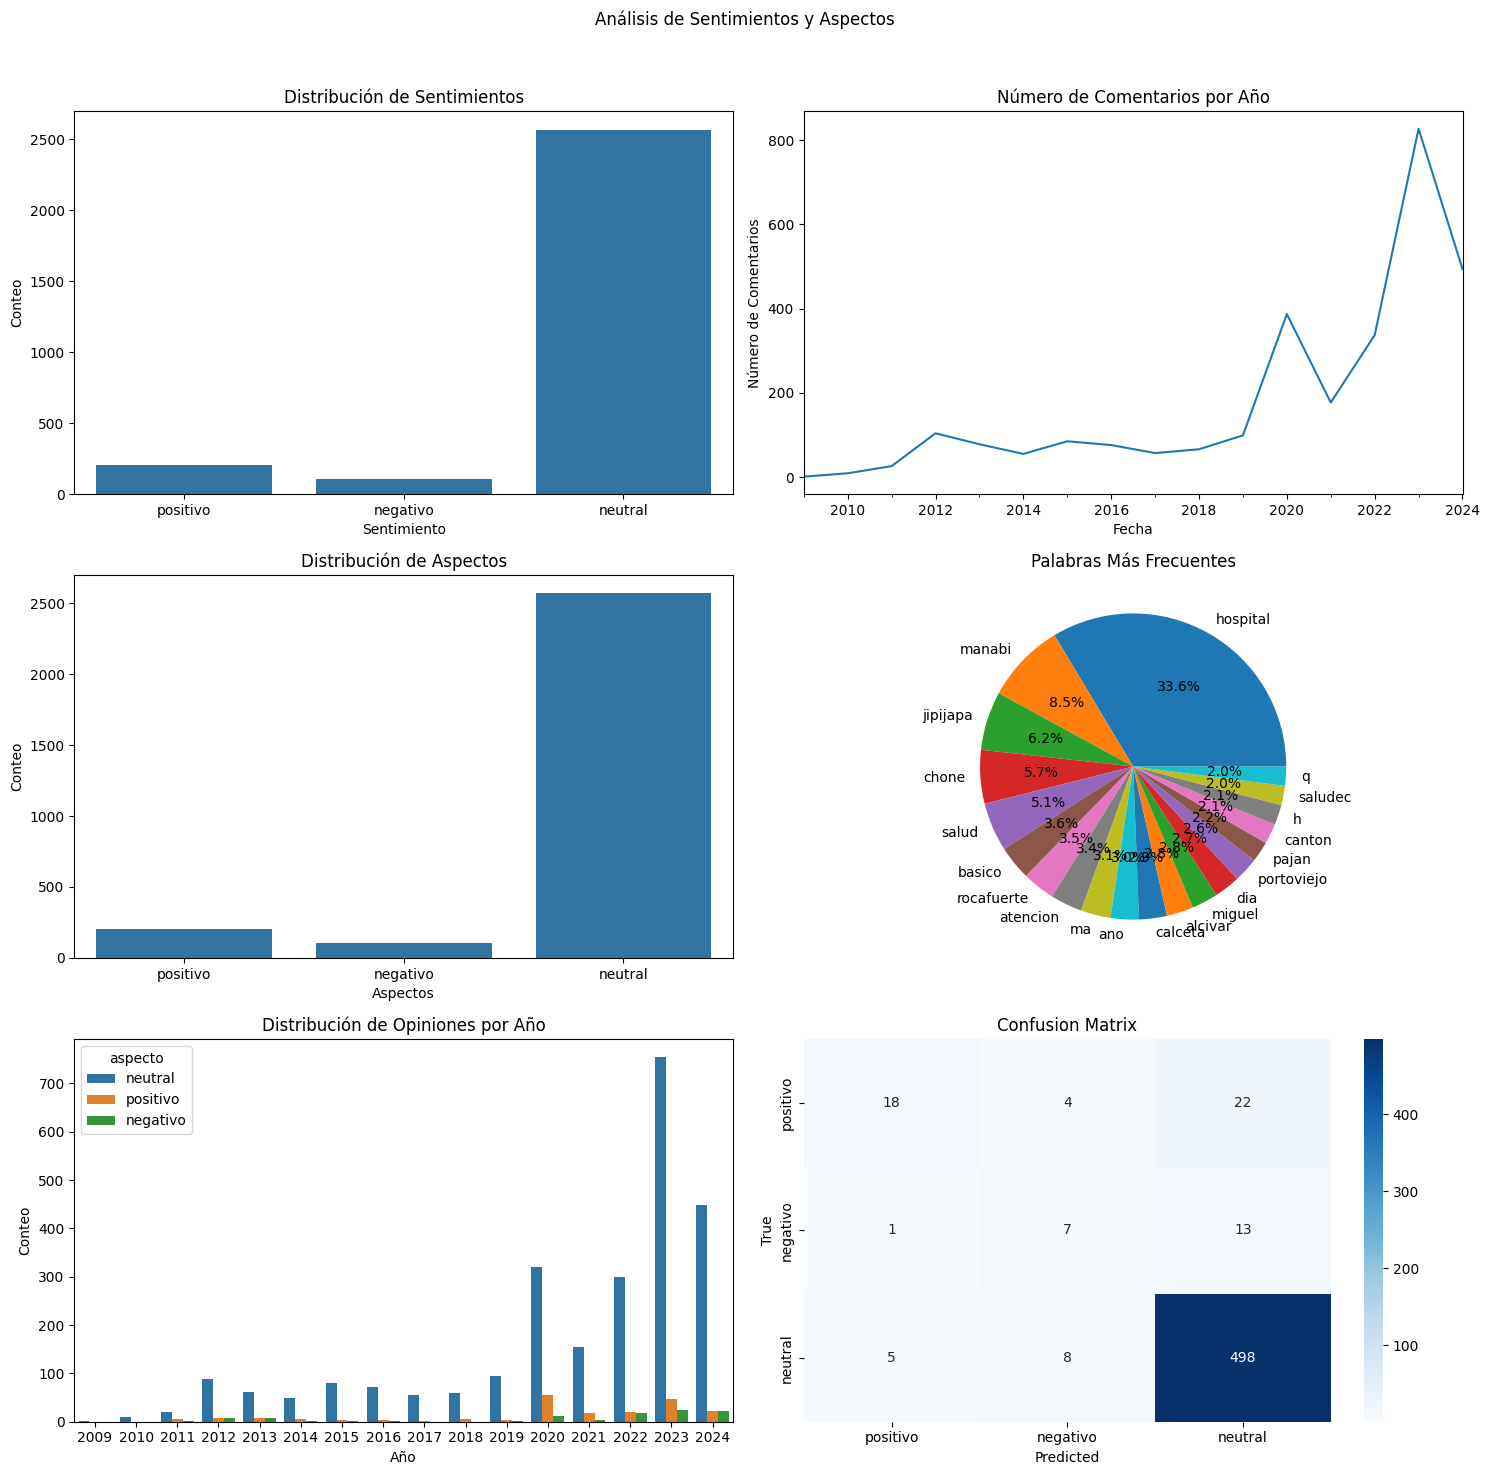

Visualizaciones generadas.


In [32]:
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle
import os

# Cargar datos
print("Cargando datos...")
df = pd.read_csv('datasets/datos_combinados_1.csv')
print(f"Datos cargados: {len(df)} registros, {len(df.columns)} columnas")
print(df.head(10))

# Limpiar datos
print("Limpiando datos...")
df = limpiar_datos(df)
print(f"Columnas disponibles después de limpiar los datos: {df.columns}")
print(df.head(10))

# Vectorizar texto y mostrar resultados
print("Vectorizando texto...")
tfidf_matrix, feature_names = vectorizar_texto(df)
print("Mostrando resultados de limpieza de datos...")
mostrar_resultados(df, tfidf_matrix, feature_names)

# Análisis de sentimientos
print("Análisis de sentimientos...")
df, emociones = analizar_sentimientos(df)
print(f"Columnas disponibles después del análisis de sentimientos: {df.columns}")
print(f"Emociones detectadas: { {key: len(value) for key, value in emociones.items()} }")
print(df.head(10))

# Verificar contenido de 'sentimiento_label'
print("Contenido de 'sentimiento_label':")
print(df['sentimiento'].unique())

# Verificar valores NaN antes de eliminar
print(f"Valores NaN en 'sentimiento': {df['sentimiento'].isna().sum()}")

# Manejar valores NaN
df = df.dropna(subset=['sentimiento', 'comment_limpio'])

# Verificar DataFrame después de eliminar valores NaN
print(f"Datos después de eliminar NaN en 'sentimiento': {len(df)} registros")
print(df.head(10))

# Dividir datos en entrenamiento, validación y prueba
print("Dividiendo datos en entrenamiento, validación y prueba...")
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.7*len(df)), int(.8*len(df))])
print(f"Datos de entrenamiento: {len(train_df)} registros")
print(f"Datos de validación: {len(val_df)} registros")
print(f"Datos de prueba: {len(test_df)} registros")
print(train_df.head(10))

# Verificar datos de entrenamiento
if len(train_df) == 0:
    raise ValueError("Datos de entrenamiento están vacíos.")

# Tokenizar los datos
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)  # Reducir el vocabulario a 5000 palabras
tokenizer.fit_on_texts(train_df['comment_limpio'].values)
X_train = tokenizer.texts_to_sequences(train_df['comment_limpio'].values)
X_val = tokenizer.texts_to_sequences(val_df['comment_limpio'].values)
X_test = tokenizer.texts_to_sequences(test_df['comment_limpio'].values)  # Tokenizar datos de prueba

# Padding
max_len = 50  # Reducir el maxlen a 50
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)  # Padding de datos de prueba

# Convertir etiquetas a numpy arrays
y_train = train_df['sentimiento'].values
y_val = val_df['sentimiento'].values
y_test = test_df['sentimiento'].values  # Etiquetas de prueba

# Cargar o entrenar el modelo
model, loaded_tokenizer = cargar_modelo_rnn()
if model is None or loaded_tokenizer is None:
    # Entrenar el modelo, guardar el modelo y el tokenizer
    print("Entrenando el modelo...")
    model = definir_modelo_rnn(vocab_size=5000, max_len=max_len)
    entrenar_y_guardar_modelo_rnn(model, X_train, y_train, X_val, y_val, tokenizer, epochs=50, batch_size=32)
else:
    print("Modelo cargado exitosamente.")
    tokenizer = loaded_tokenizer

# Evaluar el modelo
print("Evaluando el modelo...")
cr, cm = evaluar_modelo_rnn(model, test_df, tokenizer)

# Generar visualizaciones
print("Generando visualizaciones...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
generar_visualizaciones(df, y_test, y_pred_classes, ['positivo', 'negativo', 'neutral'])
print("Visualizaciones generadas.")